In [1]:
git_repo = '../../../../'

import sys
import os

sys.path.insert(0, os.path.join(git_repo, 'BNP_sensitivity/GMM_clustering/'))
sys.path.insert(0, '../../../../LinearResponseVariationalBayes.py/')

# Linear response libraries
import LinearResponseVariationalBayes as vb
import LinearResponseVariationalBayes.SparseObjectives as obj_lib
import LinearResponseVariationalBayes.OptimizationUtils as opt_lib

# Local libraries
import gmm_clustering_lib as gmm_utils
import modeling_lib 
import functional_sensitivity_lib as fun_sens_lib 
import utils_lib

import matplotlib.pyplot as plt
%matplotlib inline

from copy import deepcopy

import autograd
from autograd import numpy as np
from autograd import scipy as sp

import numpy as onp
import scipy as osp

# import numpy as np
# import scipy as sp

np.random.seed(453453)

import json 

# Set up model

In [2]:
# Load results from previous fit.
json_input_file = os.path.join(
    git_repo, 'BNP_sensitivity/GMM_clustering/iris_fits/bnp_full_data_fit_alpha8.0_iris.json')

with open(json_input_file, 'r') as fp:
    fit_dict = json.load(fp)
    model = gmm_utils.get_model_from_checkpoint(fit_dict)
    model_ = gmm_utils.get_model_from_checkpoint(fit_dict)
    best_param = model.global_vb_params.get_free()
    kl_hessian = gmm_utils.get_kl_hessian_from_checkpoint(fit_dict)

In [3]:
print(model.prior_params)

prior_params:
	alpha: [8.]
	prior_centroid_mean: [0.]
	prior_centroid_info: [0.1]
	prior_gamma_df: [8.]
	prior_gamma_inv_scale:
[[0.62 0.   0.   0.  ]
 [0.   0.62 0.   0.  ]
 [0.   0.   0.62 0.  ]
 [0.   0.   0.   0.62]]


# Experimenting w GH points

In [4]:
# Refit with more GH points
gh_deg = 20

model.objective.logger.print_every = 10
gmm_utils.set_gauss_hermite_points(model.vb_params, gh_deg=gh_deg)

best_param_0, converged, x_conv, f_conv, grad_conv, obj_opt, opt_results = \
    opt_lib.repeatedly_optimize(
        objective=model.objective,
        optimization_fun=lambda x: gmm_utils.precondition_and_optimize(model.objective, x),
        init_x=best_param,
        initial_optimization_fun=None,
        max_iter=100,
        gtol=1e-8, ftol=1e-8, xtol=1e-8, disp=False,
        keep_intermediate_optimizations=True)

kl_hessian_0 = model.objective.fun_free_hessian(best_param_0)
    
print('Done. ')

Iter: 0	 RMSE: 11.252659819113031	 Objective: -305.35833030090663
Iter: 1	 RMSE: 11.252659791490329	 Objective: -305.35833030091084
Optimization terminated successfully.
         Current function value: -305.358330
         Iterations: 1
         Function evaluations: 2
         Gradient evaluations: 2
         Hessian evaluations: 0
Done. 


# Define perturbation

In [5]:
e_num_clusters_class = gmm_utils.ExpectedNumClusters(model)
e_num_clusters_class.set_e_num_clusters_from_free_param(best_param_0)

influence_class = fun_sens_lib.InfluenceFunction(model, 
                        input_par = e_num_clusters_class.model.global_vb_params, 
                        output_par = e_num_clusters_class.e_num_clusters, 
                        input_to_output_converter = e_num_clusters_class.set_e_num_clusters, 
                        optimal_input_par = best_param_0,
                        objective_hessian = kl_hessian_0)

/home/runjing_liu/anaconda3/lib/python3.6/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


In [6]:
logit_theta = np.linspace(-10, 10, 100)

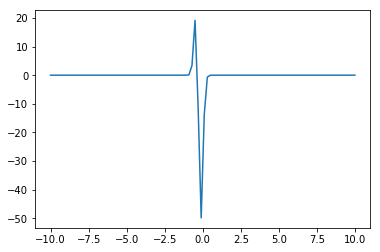

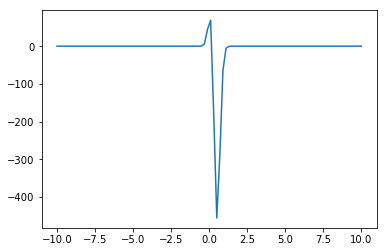

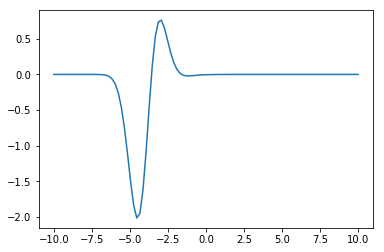

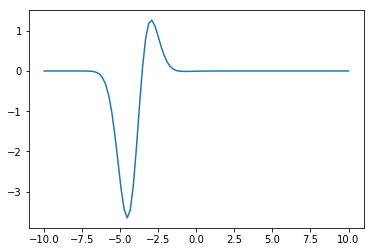

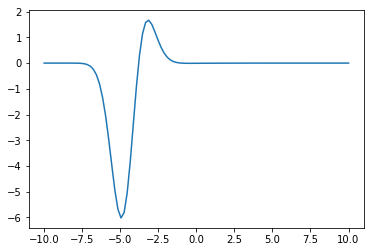

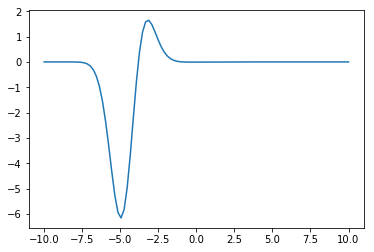

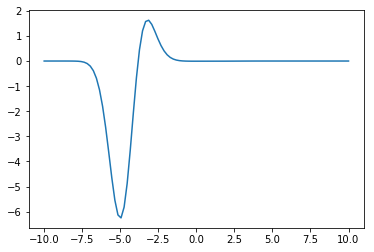

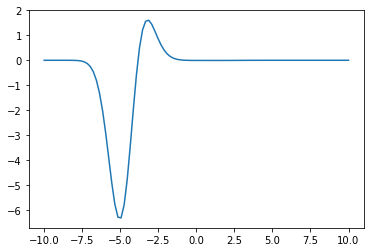

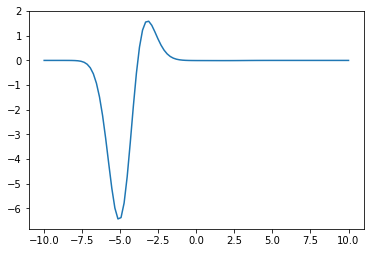

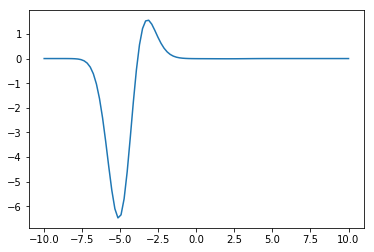

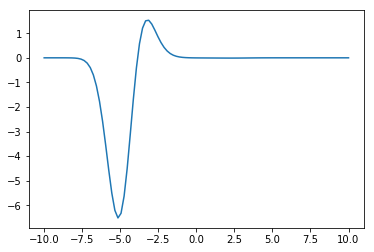

In [7]:
for k in range(model.k_approx - 1): 
    plt.figure()
    plt.plot(logit_theta, influence_class.get_influence_function_k(logit_theta, k).squeeze())

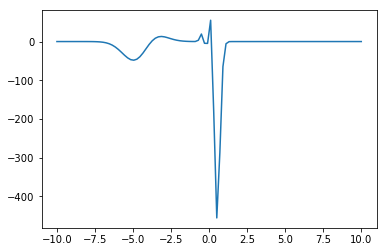

In [8]:
plt.plot(logit_theta, influence_class.get_influence_function(logit_theta))

In [9]:
import interpolation_lib as interp_lib

In [10]:
x_reg = np.linspace(-10, 10, 100)
knot_vector = x_reg
order = 3

In [11]:
logit_influence_fun_interp = interp_lib.BsplineRegression(influence_class.get_influence_function, 
                                                          x_reg, knot_vector, order)

condition number:  8.91187815224694


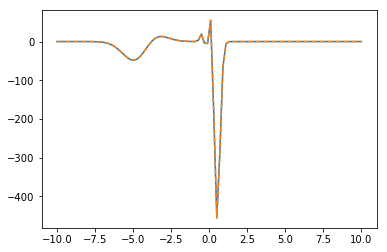

In [12]:
plt.plot(logit_theta, logit_influence_fun_interp.eval_fun(logit_theta))
plt.plot(logit_theta, logit_influence_fun_interp.eval_interp_fun(logit_theta), '--')

In [18]:
x_test = np.random.rand(1000) * 20 - 10

true_fun = logit_influence_fun_interp.eval_fun(x_test)
interp_fun = logit_influence_fun_interp.eval_interp_fun(x_test)

np.max(np.abs(true_fun - interp_fun) / np.maximum(np.abs(true_fun), 1e-6))

5.3750029633553575

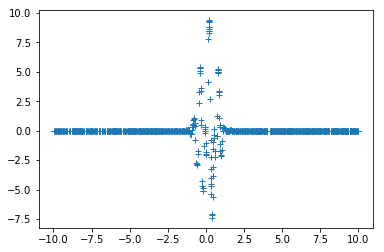

In [25]:
plt.plot(x_test, true_fun - interp_fun, '+')

In [26]:
theta = np.linspace(0.0000001, 0.9999999, 1000)

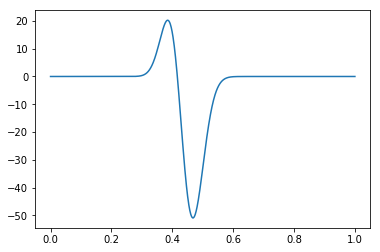

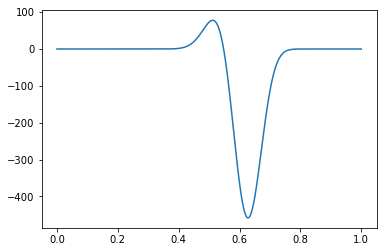

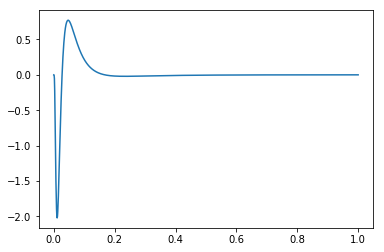

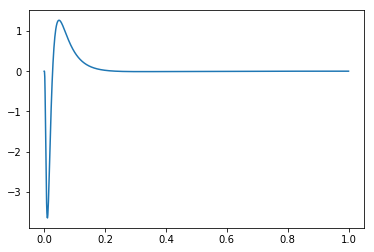

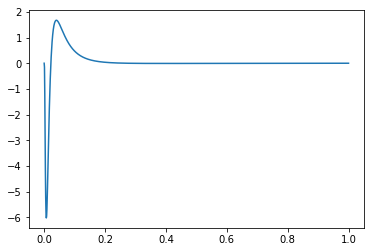

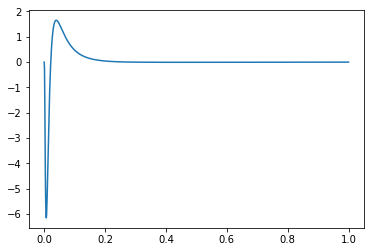

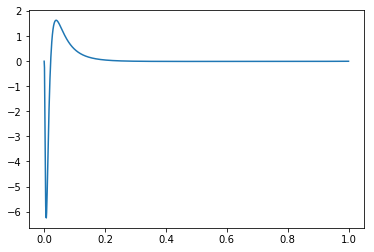

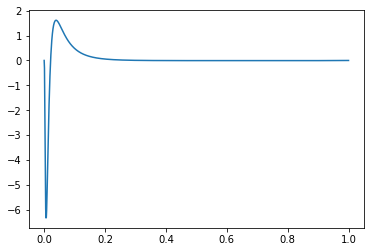

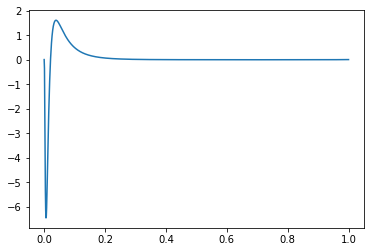

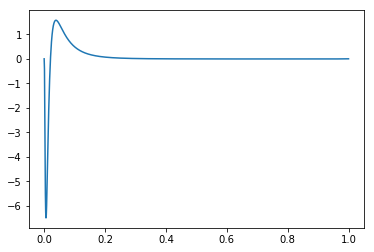

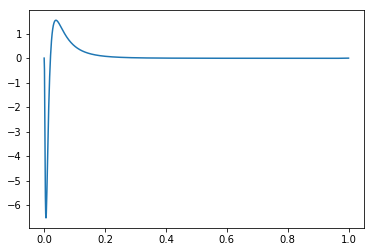

In [27]:
for k in range(model.k_approx - 1): 
    plt.figure()
    plt.plot(theta, influence_class.get_influence_function_k(sp.special.logit(theta), k).squeeze())

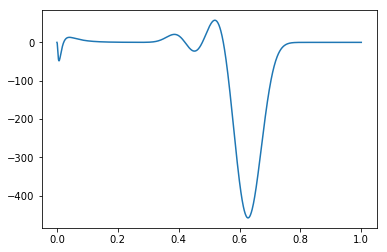

In [28]:
plt.plot(theta, influence_class.get_influence_function(sp.special.logit(theta)).squeeze())

In [29]:
# Define a perturbation in the logit v space.

# phi_center = -2
# #phi_log_rescale = stick_sens.get_log_p0_logit_stick(phi_center)
# phi_log_rescale = -np.log(0.5)
# print(phi_log_rescale)

# def log_phi(logit_v):
#     return(-0.5 * (logit_v - phi_center) ** 2 - phi_log_rescale)

# def phi(logit_v):
#     return np.exp(log_phi(logit_v))
# prior_perturbation = fun_sens_lib.PriorPerturbation(model, log_phi)
# print(
#     prior_perturbation.log_norm_p0,
#     prior_perturbation.log_norm_pc,
#     prior_perturbation.log_norm_p0_logit,
#     prior_perturbation.log_norm_pc_logit)

In [31]:
def log_phi_neg(logit_v): 
    return np.log(np.maximum(-logit_influence_fun_interp.eval_interp_fun(logit_v), 1e-12))

def log_phi_pos(logit_v): 
    return np.log(np.maximum(logit_influence_fun_interp.eval_interp_fun(logit_v), 1e-12))

In [94]:
prior_perturbation = fun_sens_lib.PriorPerturbation(model, 
                                                    log_phi = log_phi_neg,
                                                    logit_v_ub = 10,
                                                    logit_v_lb = -10)

/home/runjing_liu/anaconda3/lib/python3.6/site-packages/scipy/integrate/quadrature.py:199: AccuracyWarning: maxiter (50) exceeded. Latest difference = 3.683014e-01
  AccuracyWarning)
/home/runjing_liu/anaconda3/lib/python3.6/site-packages/scipy/integrate/quadrature.py:199: AccuracyWarning: maxiter (50) exceeded. Latest difference = 5.038237e-01
  AccuracyWarning)


/home/runjing_liu/anaconda3/lib/python3.6/site-packages/scipy/integrate/quadrature.py:199: AccuracyWarning: maxiter (50) exceeded. Latest difference = 3.683014e-01
  AccuracyWarning)
/home/runjing_liu/anaconda3/lib/python3.6/site-packages/scipy/integrate/quadrature.py:199: AccuracyWarning: maxiter (50) exceeded. Latest difference = 5.038237e-01
  AccuracyWarning)


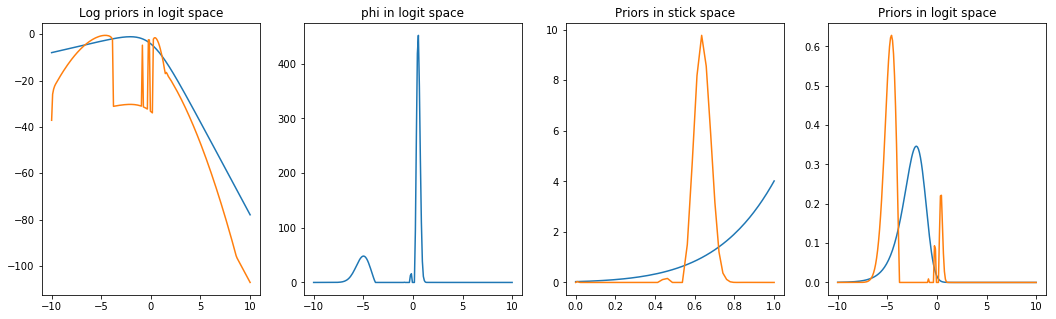

In [95]:
prior_perturbation.set_epsilon(1.0)

logit_v_grid = np.linspace(prior_perturbation.logit_v_lb, 
                           prior_perturbation.logit_v_ub, 
                           200)
v_grid = np.exp(logit_v_grid) / (1 + np.exp(logit_v_grid))

plt.figure(1, figsize=(18, 5))

#plt.plot(v_grid, phi(logit_v_grid))
plt.subplot(141)
plt.plot(logit_v_grid, prior_perturbation.get_log_p0_logit(logit_v_grid))
plt.plot(logit_v_grid, prior_perturbation.get_log_pc_logit(logit_v_grid))
plt.title('Log priors in logit space')

plt.subplot(142)
plt.plot(logit_v_grid, np.exp(prior_perturbation.log_phi(logit_v_grid)))
plt.title('phi in logit space')

plt.subplot(143)
plt.plot(v_grid, np.exp(prior_perturbation.get_log_p0(v_grid)))
plt.plot(v_grid, np.exp(prior_perturbation.get_log_pc(v_grid)))
plt.title('Priors in stick space')

plt.subplot(144)
plt.plot(logit_v_grid, np.exp(prior_perturbation.get_log_p0_logit(logit_v_grid)))
plt.plot(logit_v_grid, np.exp(prior_perturbation.get_log_pc_logit(logit_v_grid)))
plt.title('Priors in logit space')


In [96]:
# This expects the hyperparameter to be at its optimal value.
e_num_clusters_class = gmm_utils.ExpectedNumClusters(model)
e_num_clusters_class.set_e_num_clusters_from_free_param(best_param_0)

prior_perturbation.set_epsilon(0.0)
epsilon_sensitivity = \
    obj_lib.ParametricSensitivity(
        objective_fun=model.set_z_get_kl,
        input_par=e_num_clusters_class.model.global_vb_params,
        output_par=e_num_clusters_class.e_num_clusters,
        hyper_par=prior_perturbation.epsilon_param,
        input_to_output_converter=e_num_clusters_class.set_e_num_clusters,
        optimal_input_par=best_param_0,
        objective_hessian=kl_hessian_0,
        hyper_par_objective_fun=prior_perturbation.get_e_log_perturbation)

In [97]:
prior_perturbation.get_e_log_perturbation()
np.linalg.norm(epsilon_sensitivity.get_dinput_dhyper())

45.245210169376044

# Fit with perturbation

In [98]:
epsilon = 1.0 # prior_perturbation.epsilon_param.get()
print('Epsilon: ', epsilon)

best_param_phi_pred = \
    epsilon_sensitivity.predict_input_par_from_hyperparameters(epsilon)
output_phi_pred = epsilon_sensitivity.predict_output_par_from_hyperparameters(
    epsilon, linear=True)

print('Predicted differences: ', np.linalg.norm(best_param_phi_pred - best_param_0))

Epsilon:  1.0
Predicted differences:  45.245210169376044


In [99]:
# Then fit with the perturbation.
prior_perturbation.set_epsilon(epsilon)
print(prior_perturbation.epsilon_param)
best_param_phi, converged, x_conv, f_conv, grad_conv, obj_opt, opt_results = \
    opt_lib.repeatedly_optimize(
        objective=prior_perturbation.objective,
        optimization_fun=
            lambda x: gmm_utils.precondition_and_optimize(
                prior_perturbation.objective, x),
        init_x=best_param_phi_pred,
        initial_optimization_fun=None,
        keep_intermediate_optimizations=True)
print('Done. Converged: ', converged)

print('This is nonzero if phi did anything:', np.linalg.norm(best_param_phi - best_param_0))

epsilon: 1.0


/home/runjing_liu/anaconda3/lib/python3.6/site-packages/scipy/integrate/quadrature.py:199: AccuracyWarning: maxiter (50) exceeded. Latest difference = 3.683014e-01
  AccuracyWarning)
/home/runjing_liu/anaconda3/lib/python3.6/site-packages/scipy/integrate/quadrature.py:199: AccuracyWarning: maxiter (50) exceeded. Latest difference = 5.038237e-01
  AccuracyWarning)
/home/runjing_liu/anaconda3/lib/python3.6/site-packages/autograd/tracer.py:48: RuntimeWarning: overflow encountered in exp
  return f_raw(*args, **kwargs)
/home/runjing_liu/anaconda3/lib/python3.6/site-packages/autograd/tracer.py:48: RuntimeWarning: invalid value encountered in multiply
  return f_raw(*args, **kwargs)
/home/runjing_liu/anaconda3/lib/python3.6/site-packages/autograd/numpy/numpy_vjps.py:35: RuntimeWarning: invalid value encountered in multiply
  lambda ans, x, y : unbroadcast_f(y, lambda g: x * g))
/home/runjing_liu/anaconda3/lib/python3.6/site-packages/autograd/numpy/numpy_vjps.py:53: RuntimeWarning: overflow e

gamma Autograd ArrayBox with value [[[nan nan nan nan]
  [nan nan nan nan]
  [nan nan nan nan]
  [nan nan nan nan]]

 [[nan nan nan nan]
  [nan nan nan nan]
  [nan nan nan nan]
  [nan nan nan nan]]

 [[nan nan nan nan]
  [nan nan nan nan]
  [nan nan nan nan]
  [nan nan nan nan]]

 [[nan nan nan nan]
  [nan nan nan nan]
  [nan nan nan nan]
  [nan nan nan nan]]

 [[nan nan nan nan]
  [nan nan nan nan]
  [nan nan nan nan]
  [nan nan nan nan]]

 [[nan nan nan nan]
  [nan nan nan nan]
  [nan nan nan nan]
  [nan nan nan nan]]

 [[nan nan nan nan]
  [nan nan nan nan]
  [nan nan nan nan]
  [nan nan nan nan]]

 [[nan nan nan nan]
  [nan nan nan nan]
  [nan nan nan nan]
  [nan nan nan nan]]

 [[nan nan nan nan]
  [nan nan nan nan]
  [nan nan nan nan]
  [nan nan nan nan]]

 [[nan nan nan nan]
  [nan nan nan nan]
  [nan nan nan nan]
  [nan nan nan nan]]

 [[nan nan nan nan]
  [nan nan nan nan]
  [nan nan nan nan]
  [nan nan nan nan]]

 [[nan nan nan nan]
  [nan nan nan nan]
  [nan nan nan nan]
  [

AssertionError: 

In [ ]:
# Get e_num_clusters before and after perturbation
output_phi = e_num_clusters_class.set_and_get_e_num_clusters_from_free_param(best_param_phi)
output_0 = e_num_clusters_class.set_and_get_e_num_clusters_from_free_param(best_param_0)

# Check results

In [ ]:
print('Epsilon:', epsilon)

plt.figure()
plt.subplot(1, 2, 1)
plt.plot(best_param_phi - best_param_0, best_param_phi_pred - best_param_0, 'k.')
plt.plot(best_param_phi - best_param_0, best_param_phi - best_param_0, 'r')

# plt.subplot(1, 2, 2)
# plt.plot(output_phi - output_0, output_phi_pred - output_0, 'k.')
# plt.plot(output_phi - output_0, output_phi - output_0, 'r')

In [ ]:
output_0

In [ ]:
output_phi 

In [ ]:
output_phi_pred

# Fit with range of perturbations

In [100]:
# epsilon_vec = np.linspace(0.1, 1.0, 10)
epsilon_vec = np.linspace(0.02, 0.2, 10)
print(epsilon_vec)

[0.02 0.04 0.06 0.08 0.1  0.12 0.14 0.16 0.18 0.2 ]


In [101]:
best_param_phi_array = []
best_param_phi_pred_array = []

output_phi_array = []
output_phi_pred_array = []

In [ ]:
for i in range(len(epsilon_vec)): 
    epsilon = epsilon_vec[i]
    print('Epsilon: ', epsilon)
    
    # get linear predictions
    best_param_phi_pred = \
        epsilon_sensitivity.predict_input_par_from_hyperparameters(epsilon)
    output_phi_pred = epsilon_sensitivity.predict_output_par_from_hyperparameters(
        epsilon, linear=True)

    print('Predicted differences: ', np.linalg.norm(best_param_phi_pred - best_param_0))
    
    # Then fit with the perturbation.
    prior_perturbation.set_epsilon(epsilon_vec[i])
    print(prior_perturbation.epsilon_param)
    best_param_phi, converged, x_conv, f_conv, grad_conv, obj_opt, opt_results = \
        opt_lib.repeatedly_optimize(
            objective=prior_perturbation.objective,
            optimization_fun=
                lambda x: gmm_utils.precondition_and_optimize(
                    prior_perturbation.objective, x),
            init_x=best_param_phi_pred,
            initial_optimization_fun=None,
            keep_intermediate_optimizations=True)

    output_phi = e_num_clusters_class.set_and_get_e_num_clusters_from_free_param(best_param_phi)

    print('Done. Converged: ', converged)

    print('This is nonzero if phi did anything:', np.linalg.norm(best_param_phi - best_param_0))
    
    # save results: 
    best_param_phi_array.append(best_param_phi)
    best_param_phi_pred_array.append(best_param_phi_pred)
    
    output_phi_array.append(output_phi)
    output_phi_pred_array.append(output_phi_pred)
    

Epsilon:  0.02
Predicted differences:  0.9049042033875209
epsilon: 0.02


/home/runjing_liu/anaconda3/lib/python3.6/site-packages/scipy/integrate/quadrature.py:199: AccuracyWarning: maxiter (50) exceeded. Latest difference = 4.933930e-03
  AccuracyWarning)
/home/runjing_liu/anaconda3/lib/python3.6/site-packages/scipy/integrate/quadrature.py:199: AccuracyWarning: maxiter (50) exceeded. Latest difference = 3.641464e-02
  AccuracyWarning)


In [ ]:
np.save('worst_case_neg_results', best_param_phi_array)

In [ ]:
np.save('worst_case_neg_epsilons', epsilon_vec)

In [ ]:
output_0 = e_num_clusters_class.set_and_get_e_num_clusters_from_free_param(best_param_0)

In [ ]:
for i in range(len(epsilon_vec)): 
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.plot(best_param_phi_array[i] - best_param_0, 
             best_param_phi_pred_array[i] - best_param_0, 'k.')
    plt.plot(best_param_phi_array[i] - best_param_0, 
             best_param_phi_array[i] - best_param_0, 'r')
    plt.xlabel('true diff global free params')
    plt.ylabel('pred diff global free params')
    plt.title('epsilon = {}'.format(epsilon_vec[i]))

    plt.subplot(1, 2, 2)
    plt.plot(output_phi_array[i] - output_0, 
             output_phi_pred_array[i] - output_0, 'k.')
    plt.plot(output_phi_array[i] - output_0, 
             output_phi_array[i] - output_0, 'r')
    plt.xlabel('true diff moment params')
    plt.ylabel('pred diff moment params')
    plt.title('epsilon = {}'.format(epsilon_vec[i]))
    
    plt.tight_layout()

    

In [ ]:
plt.plot(epsilon_vec, output_phi_array, '+')
plt.plot(epsilon_vec, output_phi_pred_array, '+')


plt.xlabel('epsilon')
plt.ylabel('expected number of clusters')

plt.legend(('computed', 'linear approximation'))

plt.savefig('../../../writing/functional_sensitivity_writing/func_sens_results/worst_case_pos_influence.png')

In [ ]:
output_phi_pred_nonlin_array = []
for i in range(len(epsilon_vec)): 
    output_phi_pred_nonlin_array.append(
        epsilon_sensitivity.predict_output_par_from_hyperparameters(epsilon_vec[i], linear = False))

In [ ]:
plt.plot(epsilon_vec, output_phi_array, '+')
plt.plot(epsilon_vec, output_phi_pred_nonlin_array, '+')